##Hackathon:

### Pre-requisites:

In [1]:
import numpy as np
import scipy.stats
import scipy.special
from sklearn import decomposition
from sklearn import linear_model
from sklearn.pipeline import Pipeline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
import math
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
import collections

###Dataset:

In [2]:
df=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
df.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [3]:
#df['atmospheric_temperature(°C)']=df['atmospheric_temperature(°C)'].where(df['atmospheric_temperature(°C)']>0,0)
#test['atmospheric_temperature(°C)']=test['atmospheric_temperature(°C)'].where(test['atmospheric_temperature(°C)']>0,0)

df['blade_length(m)']=df['blade_length(m)'].where(df['blade_length(m)']>0,np.abs(np.mean(df['blade_length(m)'])))
test['blade_length(m)']=test['blade_length(m)'].where(test['blade_length(m)']>0,np.abs(np.mean(df['blade_length(m)'])))
df['windmill_height(m)']=df['windmill_height(m)'].where(df['windmill_height(m)']>0,np.abs(np.mean(df['windmill_height(m)'])))
test['windmill_height(m)']=test['windmill_height(m)'].where(test['windmill_height(m)']>0,np.abs(np.mean(df['windmill_height(m)'])))
df['blade_breadth(m)']=df['blade_breadth(m)'].where(df['blade_breadth(m)']>0,np.abs(np.mean(df['blade_breadth(m)'])))
test['blade_breadth(m)']=test['blade_breadth(m)'].where(test['blade_breadth(m)']>0,np.abs(np.mean(df['blade_breadth(m)'])))

In [4]:
df.set_index(['tracking_id','datetime'],inplace=True)

In [ ]:
#test.set_index(['tracking_id','datetime'],inplace=True)

In [5]:
df.head()

,,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
tracking_id,datetime,,,,,,,,,,,,,,,,,,,,
WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,2.254034,0.453374,27.971650,3.519074


In [6]:
#helper function to view the table content details
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=52):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

In [7]:
tbl_report(df)

Table Shape (28200, 20)


,dtype,nulls,uniques,num_uniques,value_counts
wind_speed(m/s),float64,273,"[94.82002337205151, 241.8327342433292, 95.4847243168022, 238.819424189392, 10.722890034533624, 93.76997287836076, 16.026249029661933, 48.73782575701743, 47.081728605137435, 283.78932912653124, 91.9961731037127, 92.77435084676227, 11.596508369650849, 11.113761449401425, 94.72313775163587, 35.867840638735416, 94.76680098841206, 95.30274133172655, 95.86879756150196, 96.32447536169508, 213.15445133025818, 97.08315676734907, 47.114686046262605, 94.71450819079368, 216.1102342911552, -15.470202344412955, 94.38394160845327, 94.6603954969745, 94.76974766691835, 93.89667919935222, 91.67307974851096, 96.51544779731844, 91.25964007168078, 92.8955327034388, 47.83110895179132, 94.1689305075137, 96.53786561562069, 91.93107761853277, 47.962430711268695, 18.45930416091365, 24.15391439701878, 10.12638413982543, 31.47093272968118, 92.40456979473105, 35.40990333535884, 96.12016002587515, -93.68243575518841, 94.39168997696443, 23.96101948188351, 33.137976042989806, 41.1763517468707, 22.521322591566747, -105.5112325344684, 15.164625501776648, 92.9674683445302, 95.59342228670245, 93.16672101092718, 94.79779770079371, 10.66278423447213, 160.75648214555181, 136.49995634936272, 33.65255490654908, 96.66237622390352, 17.875234762734504, 36.756861577147454, 14.016831744109775, 95.15780304974156, 10.100845571200704, 19.06039560259474, 94.714962077366, 95.53960900710163, 95.52243496734951, 93.5700652941682, 255.62772822249087, 19.62234906132207, 95.34603804846466, 93.0574543591234, 94.68534906045956, 10.0, -110.02313265078578, 92.67583713339664, 96.77466437413341, 17.521311010274054, 96.89408259869305, 14.000477494816911, 92.49289244088442, 15.167768966521328, 97.82618453513969, -45.74924954090302, 34.869687949722106, -47.49682427574678, 93.50431202150595, 28.898188439463812, 93.87355807798271, 10.114610973604675, 94.1534333868874, 93.06128257187731, 27.650165042069663, 92.6935521358422, 11.250214048334108, ...]",27728,NA
atmospheric_temperature(°C),float64,3450,"[-99.0, 27.764784791126733, nan, 30.326226467517447, 12.716814737860945, 18.887932134282664, 15.843846173100946, 10.164266393529196, 12.680414144275892, 30.58851678897026, 20.87112870585453, 26.336034970150685, 15.767437335826036, 26.869915363090072, 35.612076937383314, 20.86641488346215, 25.477709969867266, 22.881021198024452, 19.958514259630554, 28.51421112555181, 23.030193835121974, 23.562381162659587, 16.935292156801367, 16.422511665501332, 21.4046745422456, 17.863520124089035, 16.814799428814382, 12.21200908662923, 9.782718616949467, 4.676663000585485, 7.780399637291532, 11.306420604464504, 9.34744342658064, 24.41741689193892, 18.06746568384261, 14.181260087213275, 10.674392267307221, 12.292925705133008, 8.411100074187758, 15.847752230670828, 22.946900461139922, 21.20765716418864, 9.94575804135124, 6.197102798586677, 10.964593929397843, 23.16400473519373, 12.91472300742056, -15.526163750122164, 27.147545217675265, 10.335041830909788, 11.800315534135287, 35.212021064610965, 23.164983034532852, 19.174247498276287, 30.156421701105323, 10.467585024711177, 19.96262633844856, 23.89504020536805, 21.02708064280013, 11.610170786198331, 19.934304135861147, 47.407288899787254, 3.763194151848843, 20.3768642691608, 26.172363565407576, 7.8952339178222894, 52.91666094485378, 24.05855985889409, 13.45557310558116, 21.959353314244627, 11.913480558096294, 24.615581433773087, 23.08694749555074, -4.1664364788227175, 10.915369058429695, 18.52529457453229, 25.644372581850792, 7.699317316373432, 19.628221070042212, 5.388858912716223, 16.510406891371805, 20.392259364852446, 19.34828400174009, 17.626664968234152, 15.558122467562091, 26.503824291216997, 17.087026281341053, 21.71249293907063, 18.693283645745552, 26.155363705868808, 11.903597975282194, 9.601692694467571, 15.645872582541408, -9.722608161376598, 9.249174741831297, 24.69734129233917, 17.06295844619637, 18.057554547676414, 28.261084594939323, 20.295249460146888, ...]",20810,NA
shaft_te

In [8]:
#variable seggregation
cat_var=['turbine_status','cloud_level']
cont_var=list(set(list(df.columns))-set(cat_var)-set(['tracking_id','datetime']))

In [9]:
cont_var

['blade_length(m)',
 'atmospheric_pressure(Pascal)',
 'area_temperature(°C)',
 'wind_speed(m/s)',
 'atmospheric_temperature(°C)',
 'motor_torque(N-m)',
 'shaft_temperature(°C)',
 'engine_temperature(°C)',
 'wind_direction(°)',
 'rotor_torque(N-m)',
 'windmill_body_temperature(°C)',
 'blades_angle(°)',
 'resistance(ohm)',
 'windmill_height(m)',
 'generator_temperature(°C)',
 'blade_breadth(m)',
 'windmill_generated_power(kW/h)',
 'gearbox_temperature(°C)']

In [10]:
null_var=list(set(list(df.columns[df.isna().any(axis=0)]))-set(cat_var))
null_var

['atmospheric_pressure(Pascal)',
 'wind_speed(m/s)',
 'atmospheric_temperature(°C)',
 'motor_torque(N-m)',
 'shaft_temperature(°C)',
 'engine_temperature(°C)',
 'wind_direction(°)',
 'rotor_torque(N-m)',
 'windmill_body_temperature(°C)',
 'blades_angle(°)',
 'resistance(ohm)',
 'generator_temperature(°C)',
 'gearbox_temperature(°C)',
 'windmill_generated_power(kW/h)']

In [11]:
#null handled in categorical variables
df['turbine_status'].fillna('BB',inplace=True)
df['cloud_level'].fillna('Low',inplace=True)
test['turbine_status'].fillna('BB',inplace=True)
test['cloud_level'].fillna('Low',inplace=True)

In [12]:
#cleaning data
df.dropna(how='all',inplace=True)
test.dropna(how='all',inplace=True)

In [13]:
 #null handling for continuos variables
 for i in null_var:
   print(np.mean(df[i]))
   df[i].fillna(np.mean(df[i]),inplace=True)
   if i!='windmill_generated_power(kW/h)':
      test[i].fillna(np.mean(df[i]),inplace=True)

53185.06488259962
69.03707138529741
0.38372707049757543
1710.8198030472768
40.08538671237109
42.614238563101054
306.8888829693141
25.849894051161193
20.799760568237538
-9.654038031619798
1575.56001149297
65.02785702352014
41.02775488085657
6.13052929612566


In [14]:
tbl_report(df)

Table Shape (28200, 20)


,dtype,nulls,uniques,num_uniques,value_counts
wind_speed(m/s),float64,0,"[94.82002337205151, 241.8327342433292, 95.4847243168022, 238.819424189392, 10.722890034533624, 93.76997287836076, 16.026249029661933, 48.73782575701743, 47.081728605137435, 283.78932912653124, 91.9961731037127, 92.77435084676227, 11.596508369650849, 11.113761449401425, 94.72313775163587, 35.867840638735416, 94.76680098841206, 95.30274133172655, 95.86879756150196, 96.32447536169508, 213.15445133025818, 97.08315676734907, 47.114686046262605, 94.71450819079368, 216.1102342911552, -15.470202344412955, 94.38394160845327, 94.6603954969745, 94.76974766691835, 93.89667919935222, 91.67307974851096, 96.51544779731844, 91.25964007168078, 92.8955327034388, 47.83110895179132, 94.1689305075137, 96.53786561562069, 91.93107761853277, 47.962430711268695, 18.45930416091365, 24.15391439701878, 10.12638413982543, 31.47093272968118, 92.40456979473105, 35.40990333535884, 96.12016002587515, -93.68243575518841, 94.39168997696443, 23.96101948188351, 33.137976042989806, 41.1763517468707, 22.521322591566747, -105.5112325344684, 15.164625501776648, 92.9674683445302, 95.59342228670245, 93.16672101092718, 94.79779770079371, 10.66278423447213, 160.75648214555181, 136.49995634936272, 33.65255490654908, 96.66237622390352, 17.875234762734504, 36.756861577147454, 14.016831744109775, 95.15780304974156, 10.100845571200704, 19.06039560259474, 94.714962077366, 95.53960900710163, 95.52243496734951, 93.5700652941682, 255.62772822249087, 19.62234906132207, 95.34603804846466, 93.0574543591234, 94.68534906045956, 10.0, -110.02313265078578, 92.67583713339664, 96.77466437413341, 17.521311010274054, 96.89408259869305, 14.000477494816911, 92.49289244088442, 15.167768966521328, 97.82618453513969, -45.74924954090302, 34.869687949722106, -47.49682427574678, 93.50431202150595, 28.898188439463812, 93.87355807798271, 10.114610973604675, 94.1534333868874, 93.06128257187731, 27.650165042069663, 92.6935521358422, 11.250214048334108, ...]",27728,NA
atmospheric_temperature(°C),float64,0,"[-99.0, 27.764784791126733, 0.38372707049757543, 30.326226467517447, 12.716814737860945, 18.887932134282664, 15.843846173100946, 10.164266393529196, 12.680414144275892, 30.58851678897026, 20.87112870585453, 26.336034970150685, 15.767437335826036, 26.869915363090072, 35.612076937383314, 20.86641488346215, 25.477709969867266, 22.881021198024452, 19.958514259630554, 28.51421112555181, 23.030193835121974, 23.562381162659587, 16.935292156801367, 16.422511665501332, 21.4046745422456, 17.863520124089035, 16.814799428814382, 12.21200908662923, 9.782718616949467, 4.676663000585485, 7.780399637291532, 11.306420604464504, 9.34744342658064, 24.41741689193892, 18.06746568384261, 14.181260087213275, 10.674392267307221, 12.292925705133008, 8.411100074187758, 15.847752230670828, 22.946900461139922, 21.20765716418864, 9.94575804135124, 6.197102798586677, 10.964593929397843, 23.16400473519373, 12.91472300742056, -15.526163750122164, 27.147545217675265, 10.335041830909788, 11.800315534135287, 35.212021064610965, 23.164983034532852, 19.174247498276287, 30.156421701105323, 10.467585024711177, 19.96262633844856, 23.89504020536805, 21.02708064280013, 11.610170786198331, 19.934304135861147, 47.407288899787254, 3.763194151848843, 20.3768642691608, 26.172363565407576, 7.8952339178222894, 52.91666094485378, 24.05855985889409, 13.45557310558116, 21.959353314244627, 11.913480558096294, 24.615581433773087, 23.08694749555074, -4.1664364788227175, 10.915369058429695, 18.52529457453229, 25.644372581850792, 7.699317316373432, 19.628221070042212, 5.388858912716223, 16.510406891371805, 20.392259364852446, 19.34828400174009, 17.626664968234152, 15.558122467562091, 26.503824291216997, 17.087026281341053, 21.71249293907063, 18.693283645745552, 26.155363705868808, 11.903597975282194, 9.601692694467571, 15.645872582541408, -9.722608161376598, 9.249174741831297, 24.69734129233917, 17.06295844619637, 18.057554547676414, 28.261084594939323, 20.295249460146888, ...]",20810,

###EDA:

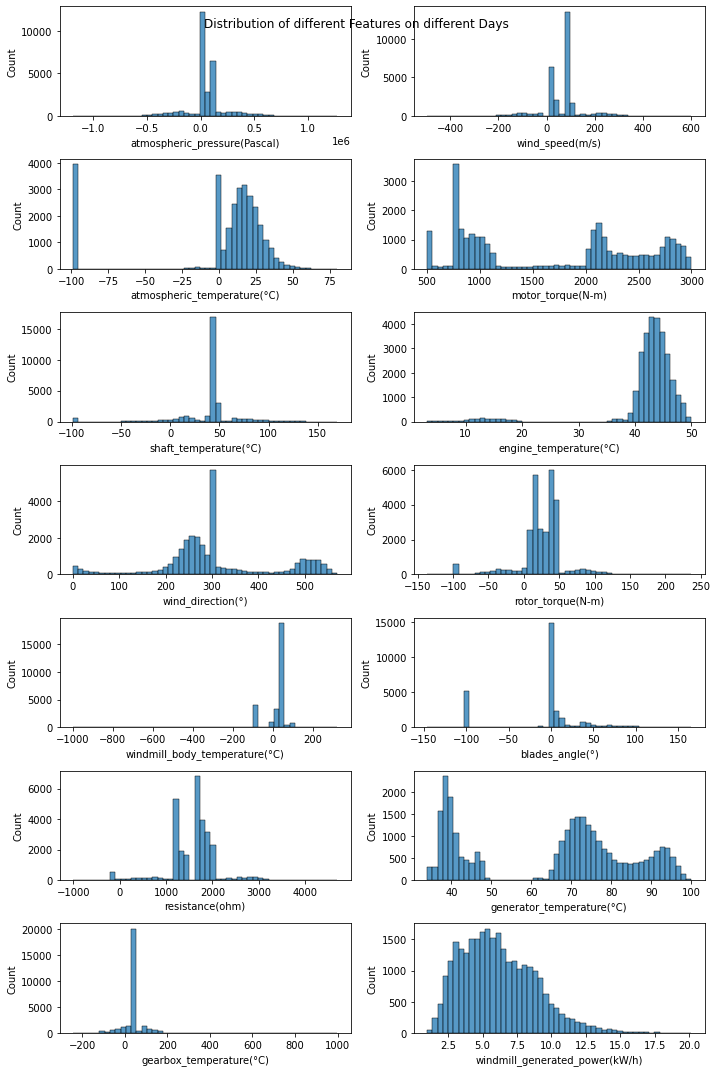

In [15]:
#plots to visualise continuous variable distributions
fig,axes=plt.subplots(7,2,figsize=(10,15))
axe=axes.ravel()
for i in range(len(axe)):
  sns.histplot(x=df[null_var[i]],bins=50,ax=axe[i],label=null_var[i],)
  axe[i].set_xlabel(null_var[i])
plt.suptitle('Distribution of different Features on different Days');
fig.tight_layout()


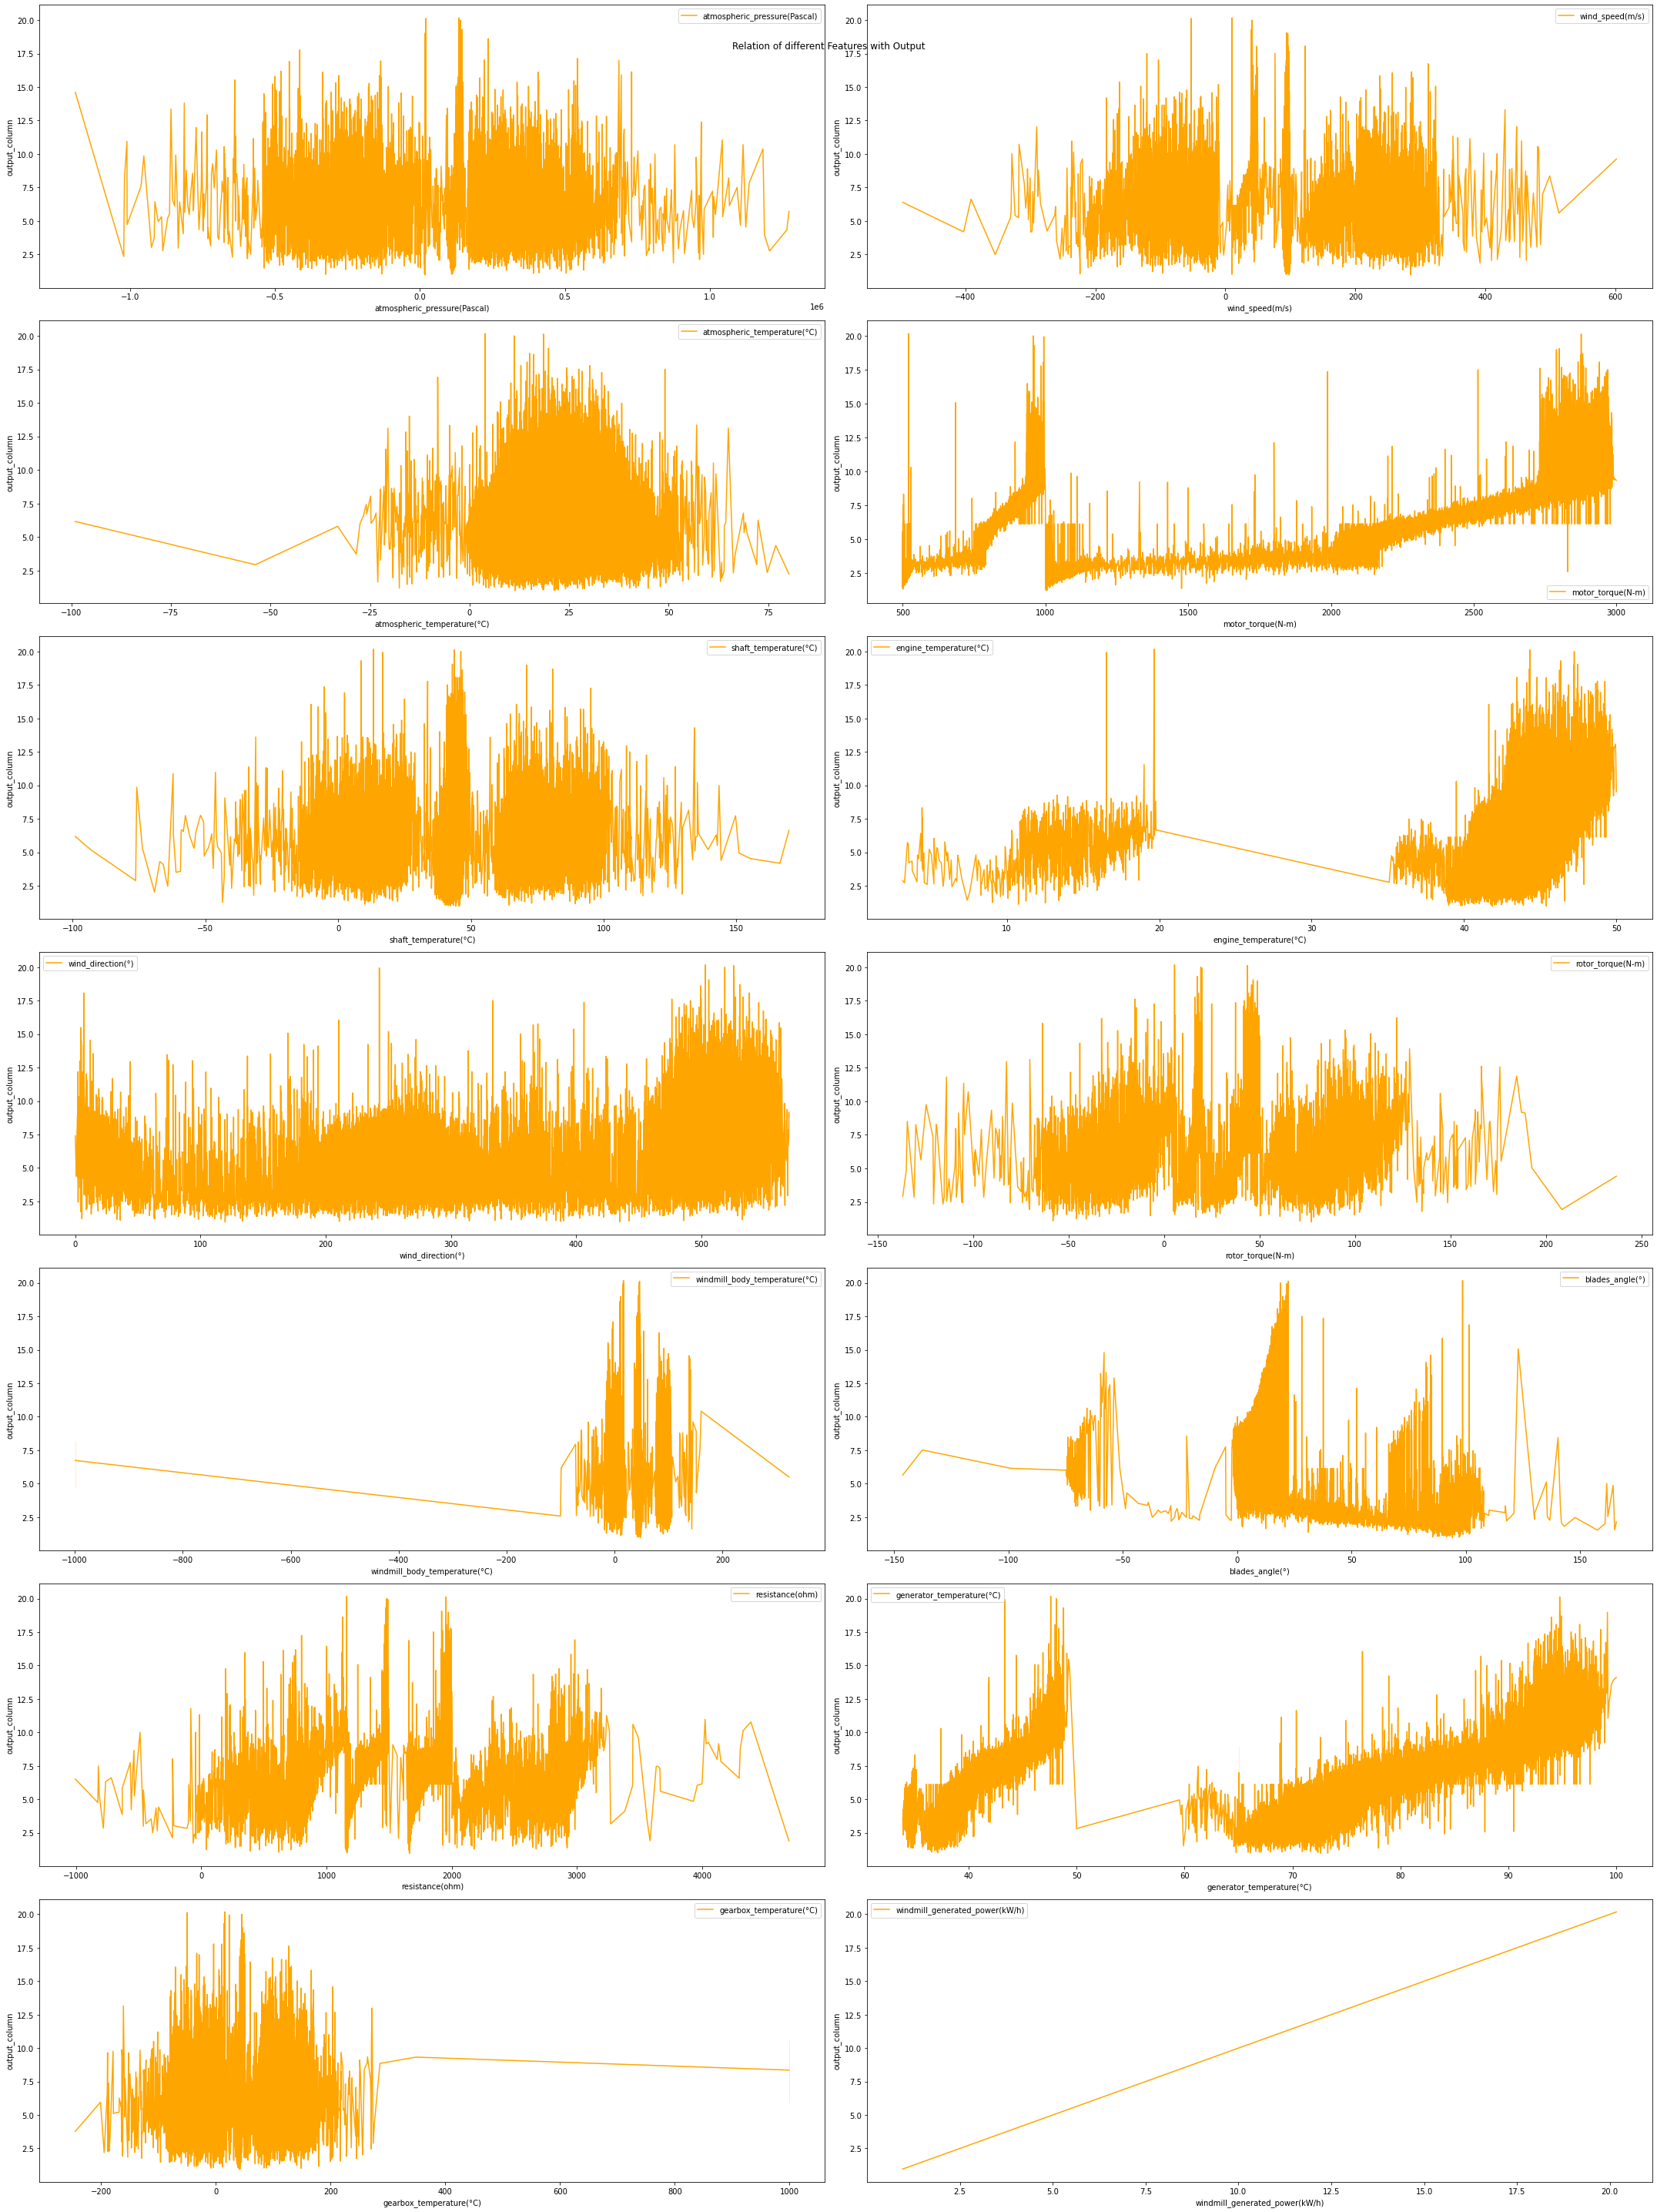

In [16]:
#plots to visualise relation between output variables
fig,axes=plt.subplots(7,2,figsize=(30,40))
axe=axes.ravel()
for i in range(len(null_var)):
  sns.lineplot(y=df['windmill_generated_power(kW/h)'],ax=axe[i],x=df[null_var[i]],label=null_var[i],color='orange')
  axe[i].set_xlabel(null_var[i])
  axe[i].set_ylabel('output_column')
plt.suptitle('Relation of different Features with Output');
fig.tight_layout()

Text(0.5, 0.98, 'Relation of different Categorical Features with Output')

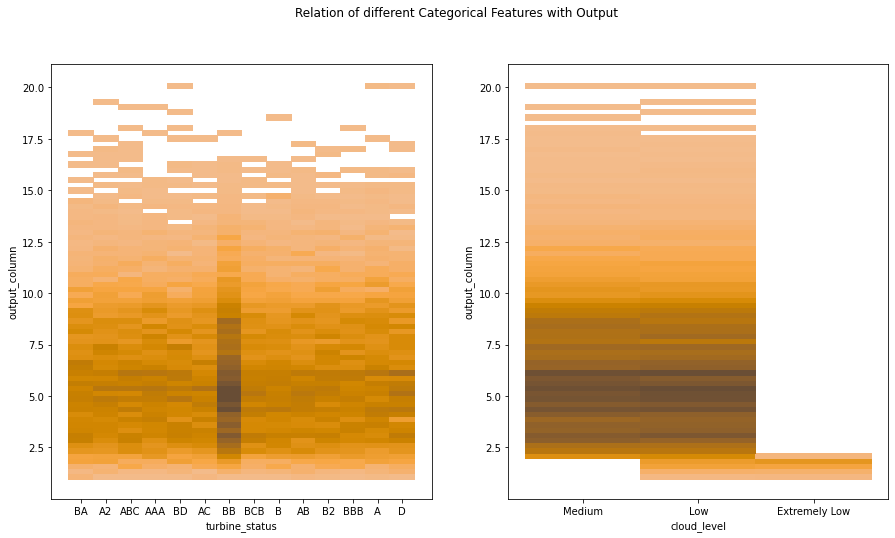

In [17]:
#relation with categorical variables
fig,axes=plt.subplots(1,2,figsize=(15,8))
axe=axes.ravel()
for i in range(len(cat_var)):
  sns.histplot(y=df['windmill_generated_power(kW/h)'],ax=axe[i],x=df[cat_var[i]],label=cat_var[i],color='orange')
  axe[i].set_xlabel(cat_var[i])
  axe[i].set_ylabel('output_column')
plt.suptitle('Relation of different Categorical Features with Output')


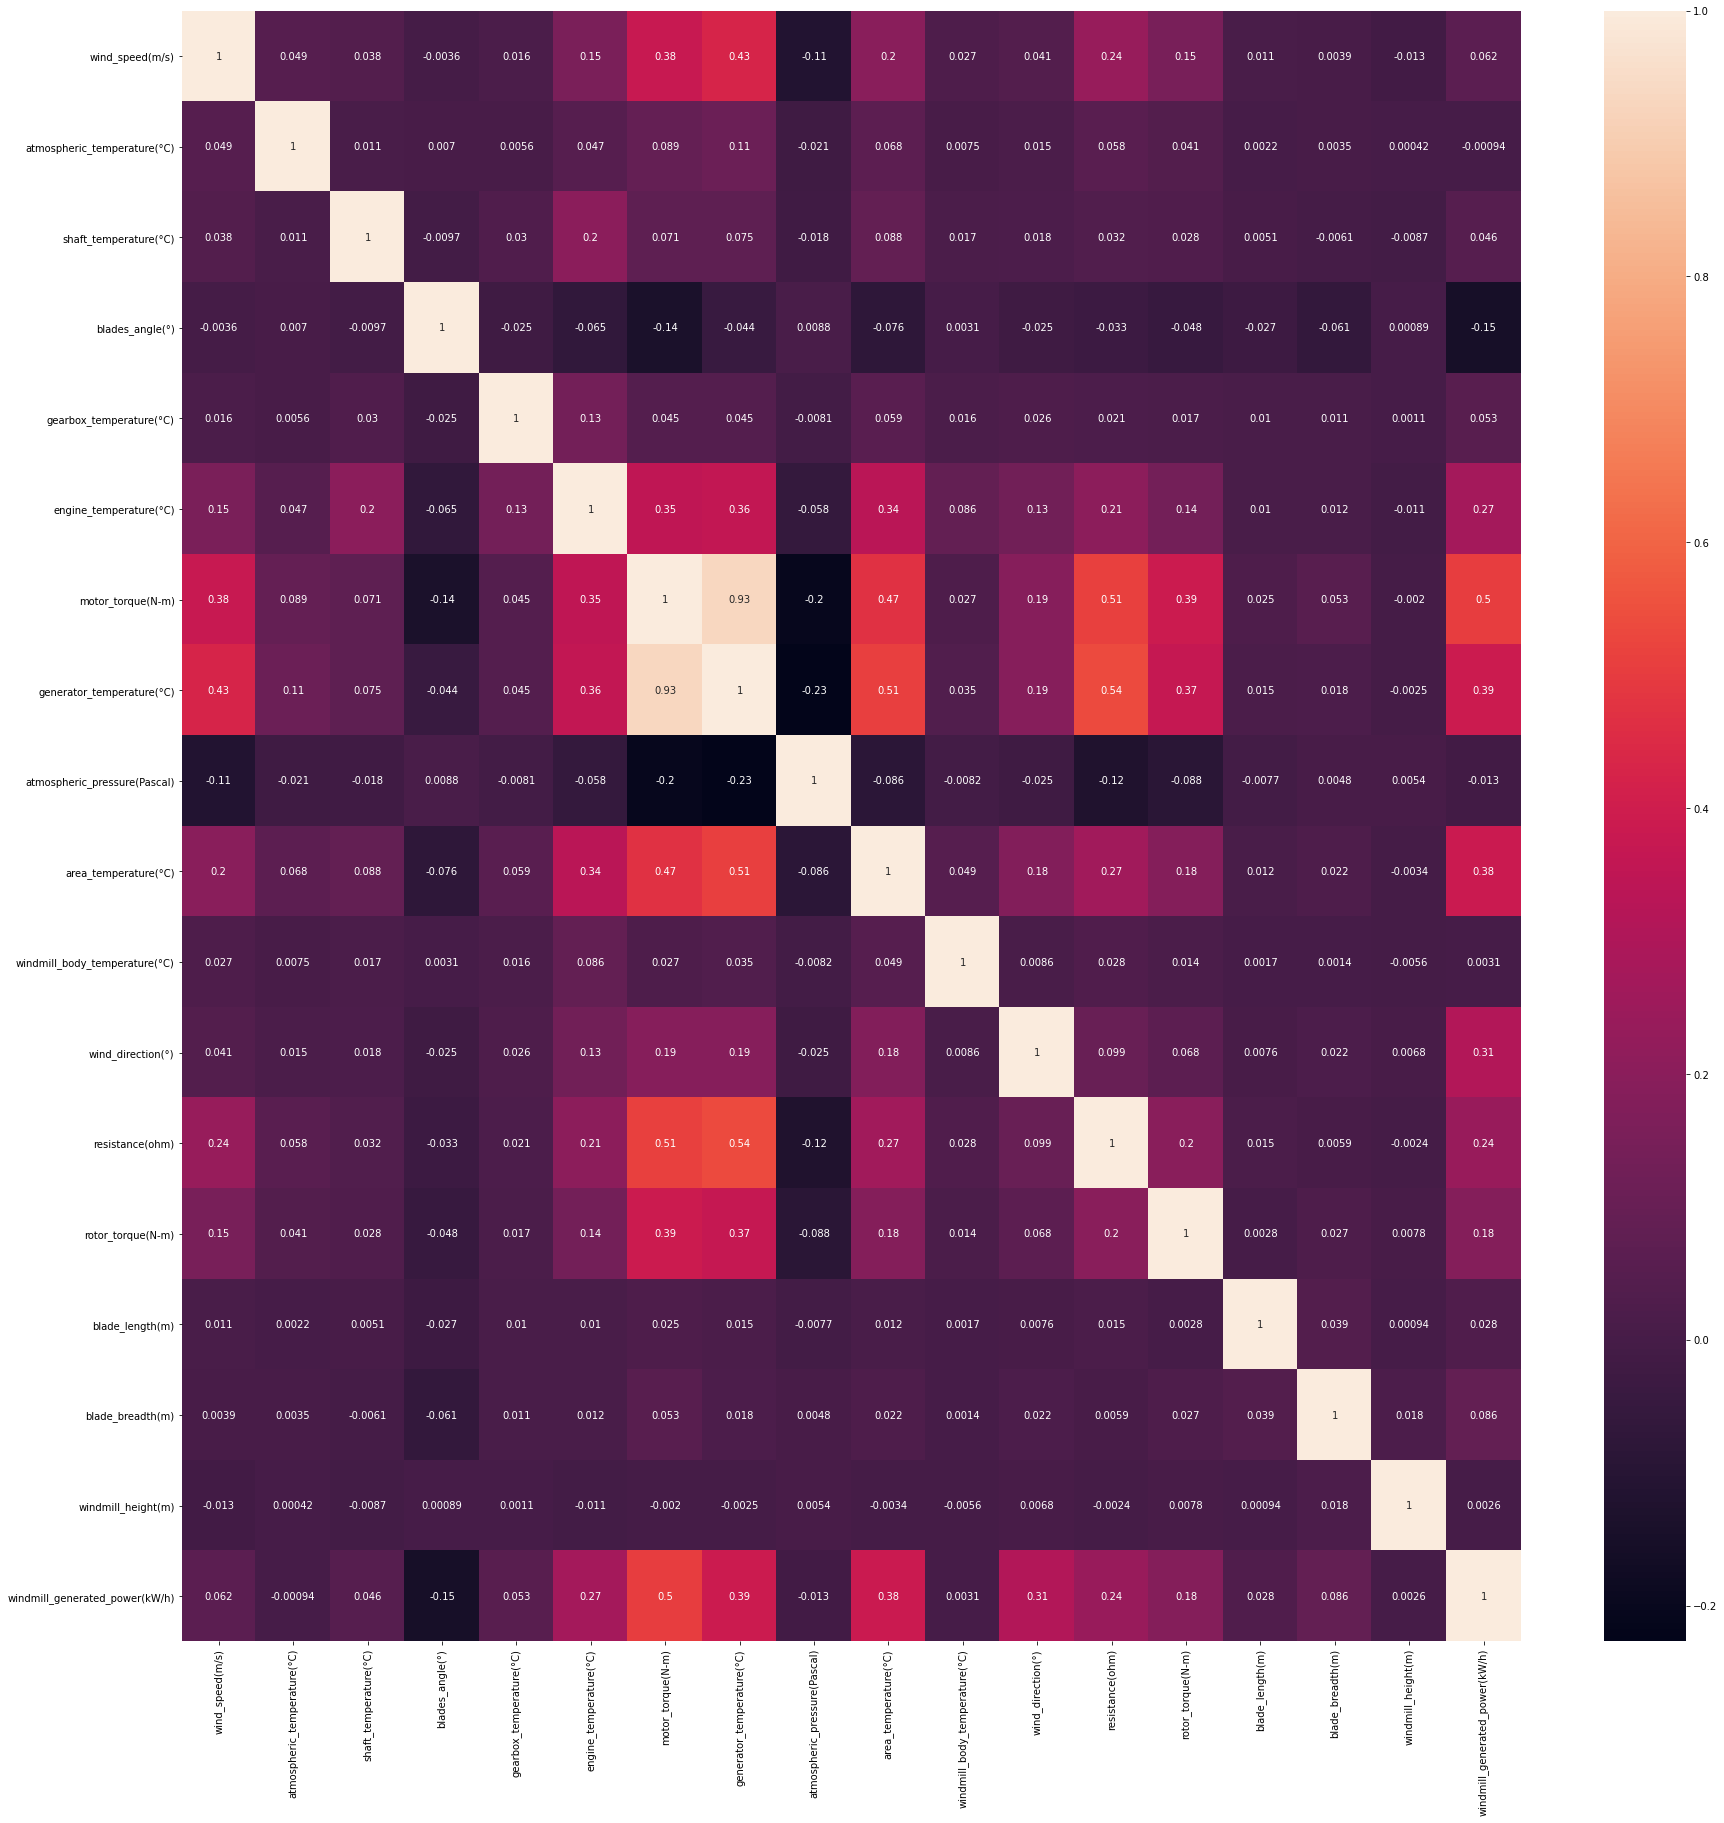

In [18]:
#correlation between features
fig,ax=plt.subplots(figsize=(30,30))
sns.heatmap(df.corr(),annot=True,ax=ax)

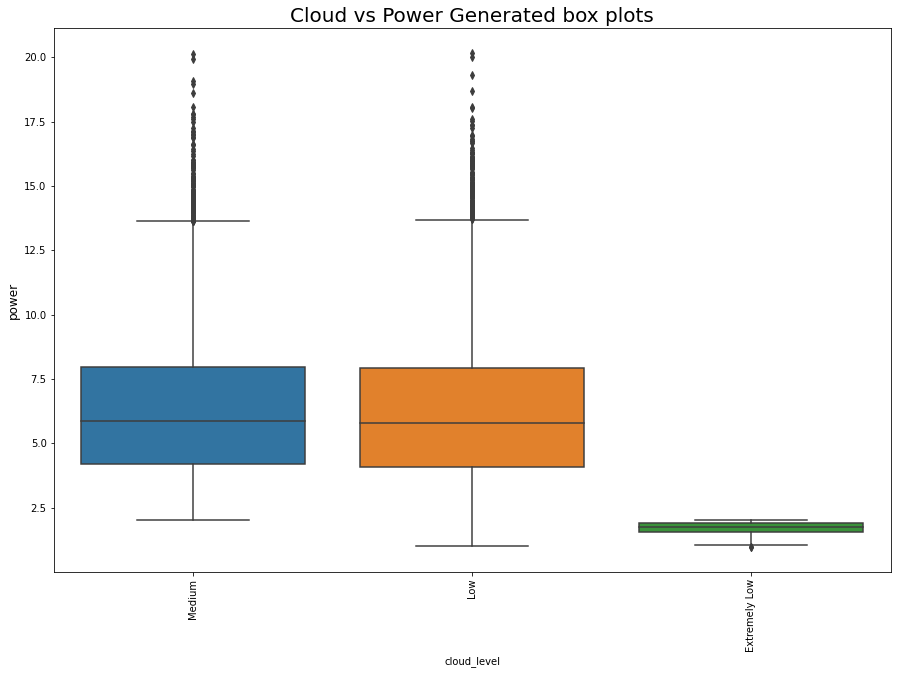

In [19]:
fig = plt.figure(figsize=(15, 10))
sns.boxplot(x = 'cloud_level', y = 'windmill_generated_power(kW/h)', data = df)
plt.title("Cloud vs Power Generated box plots",fontsize = 20)
plt.ylabel('power', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('cloud_level', fontsize = 10);

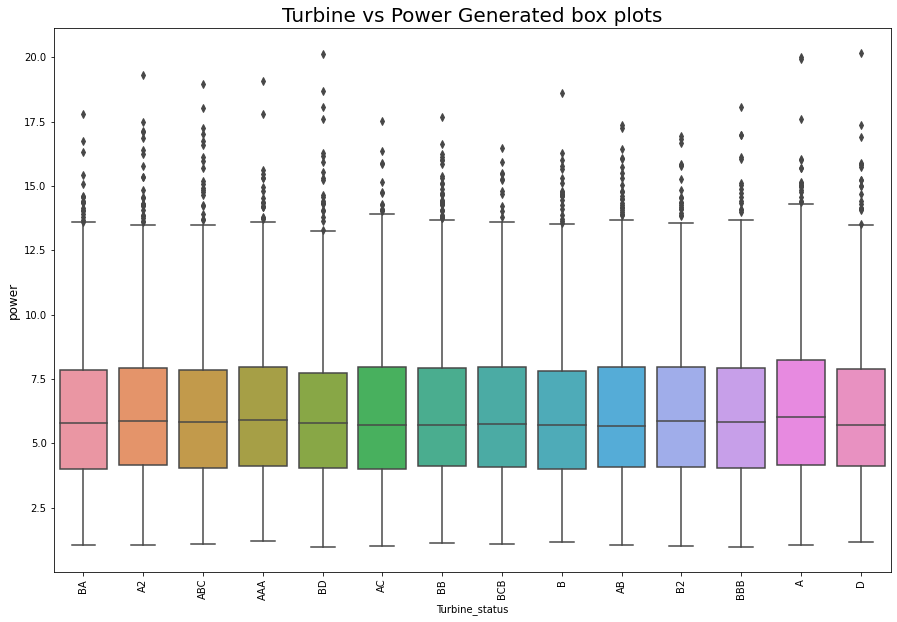

In [20]:
fig = plt.figure(figsize=(15, 10))
sns.boxplot(x = 'turbine_status', y = 'windmill_generated_power(kW/h)', data = df)
plt.title("Turbine vs Power Generated box plots",fontsize = 20)
plt.ylabel('power', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Turbine_status', fontsize = 10);

###Model:

In [21]:
X=df.drop('windmill_generated_power(kW/h)',axis=1)
y=df['windmill_generated_power(kW/h)']

In [22]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,train_size=0.7)

In [23]:
cont_var=list(set(cont_var)-set(['windmill_generated_power(kW/h)']))

In [24]:
std=StandardScaler()

In [26]:
Xtrain_scaled=Xtrain
Xtest_scaled=Xtest
test_scaled=test

In [28]:
Xtrain_scaled[cont_var]=std.fit_transform(Xtrain_scaled[cont_var])
Xtest_scaled[cont_var]=std.fit_transform(Xtest_scaled[cont_var])
test_scaled[cont_var]=std.fit_transform(test_scaled[cont_var])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [29]:
Xtrain_scaled[cat_var[0]]=Xtrain_scaled[cat_var[0]].astype('category').cat.codes.values
Xtrain_scaled[cat_var[1]]=Xtrain_scaled[cat_var[1]].astype('category').cat.codes.values
Xtest_scaled[cat_var[0]]=Xtest_scaled[cat_var[0]].astype('category').cat.codes.values
Xtest_scaled[cat_var[1]]=Xtest_scaled[cat_var[1]].astype('category').cat.codes.values
test_scaled[cat_var[0]]=test_scaled[cat_var[0]].astype('category').cat.codes.values
test_scaled[cat_var[1]]=test_scaled[cat_var[1]].astype('category').cat.codes.values


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [33]:
pca = decomposition.PCA()
linear = linear_model.LinearRegression()
pipe = Pipeline(steps=[('pca', pca),('linear', linear)])
n_components = list(range(1,Xtrain_scaled.shape[1]+1,1))
normalize = [True, False]
parameters = dict(pca__n_components=n_components,
                      linear__normalize=normalize)


In [34]:
clf = GridSearchCV(pipe, parameters)
clf.fit(Xtrain_scaled, ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('linear',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'linear__normalize': [True, False],
                         'pca__n_com

In [35]:
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['linear'])

Best Number Of Components: 19

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [36]:
from sklearn.metrics import r2_score
r2_score(ytrain,clf.predict(Xtrain_scaled))

0.41573709078099097

In [30]:
from sklearn.tree import DecisionTreeRegressor
dtree=DecisionTreeRegressor(max_depth=8)
dtree.fit(Xtrain,ytrain)



DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [37]:
r2_score(ytest,dtree.predict(Xtest))

0.9060445751644757

In [50]:
rf=RandomForestRegressor(max_depth=8,n_estimators=100,min_samples_leaf=3)
rf.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
r2_score(ytest,rf.predict(Xtest))

0.9312638882106009

In [52]:
sub=pd.read_csv('/content/sample_submission.csv')

In [53]:
sub.head()

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,6.766521
1,WM_698,2018-11-05 10:13:20,5.966275
2,WM_39146,2019-09-14 14:03:20,2.874342
3,WM_6757,2018-12-25 15:33:20,14.851089
4,WM_21521,2019-05-04 03:13:20,3.519074


In [54]:
tbl_report(test)

Table Shape (12086, 21)


,dtype,nulls,uniques,num_uniques,value_counts
tracking_id,object,0,"[WM_19817, WM_18723, WM_34552, WM_28570, WM_36934, WM_46, WM_5545, WM_6959, WM_9565, WM_33379, WM_24358, WM_38536, WM_30740, WM_32731, WM_14062, WM_15294, WM_36014, WM_5050, WM_17819, WM_1759, WM_27254, WM_14482, WM_40277, WM_23364, WM_35071, WM_1240, WM_193, WM_31417, WM_37853, WM_34415, WM_20130, WM_36985, WM_32816, WM_9659, WM_34192, WM_7124, WM_35945, WM_29448, WM_26129, WM_3566, WM_1340, WM_14304, WM_22513, WM_15672, WM_28793, WM_13683, WM_8450, WM_39606, WM_33792, WM_39434, WM_16883, WM_16423, WM_19378, WM_35176, WM_39649, WM_16624, WM_25236, WM_30165, WM_11229, WM_22495, WM_1410, WM_3502, WM_11799, WM_22334, WM_37802, WM_6663, WM_29243, WM_5320, WM_16550, WM_2183, WM_3438, WM_36325, WM_8597, WM_31833, WM_10149, WM_38811, WM_31073, WM_1314, WM_28386, WM_198, WM_10525, WM_11900, WM_18459, WM_33737, WM_1851, WM_21673, WM_6566, WM_36845, WM_7916, WM_27896, WM_21392, WM_27683, WM_8769, WM_30312, WM_29472, WM_3189, WM_18130, WM_36279, WM_28062, WM_20790, ...]",12086,NA
datetime,object,0,"[2019-04-17 08:53:20, 2019-03-30 07:43:20, 2019-08-10 11:33:20, 2019-06-26 03:53:20, 2019-08-27 16:43:20, 2018-10-29 04:43:20, 2018-12-16 15:13:20, 2018-12-27 01:53:20, 2019-01-14 13:43:20, 2019-08-02 03:33:20, 2019-05-24 04:23:20, 2019-09-10 00:23:20, 2019-07-11 20:33:20, 2019-07-28 12:23:20, 2019-02-17 14:03:20, 2019-02-27 03:03:20, 2019-08-21 06:03:20, 2018-12-11 01:23:20, 2019-03-22 11:53:20, 2018-11-13 16:23:20, 2019-06-16 12:13:20, 2019-02-20 17:53:20, 2019-09-23 05:03:20, 2019-05-17 04:43:20, 2019-08-14 02:53:20, 2018-11-09 20:43:20, 2018-10-30 05:43:20, 2019-07-16 15:23:20, 2019-09-05 02:13:20, 2019-08-09 12:13:20, 2019-04-22 05:03:20, 2019-08-28 01:13:20, 2019-07-29 02:53:20, 2019-01-15 06:03:20, 2019-08-07 22:13:20, 2018-12-28 06:43:20, 2019-08-20 18:33:20, 2019-07-02 12:43:20, 2019-06-08 07:53:20, 2018-11-29 22:53:20, 2018-11-10 15:23:20, 2019-02-19 08:33:20, 2019-05-11 04:33:20, 2019-03-01 19:03:20, 2019-06-27 17:53:20, 2019-02-14 16:33:20, 2019-01-06 15:23:20, 2019-09-17 19:03:20, 2019-08-05 01:43:20, 2019-09-16 14:23:20, 2019-03-14 00:13:20, 2019-03-08 21:13:20, 2019-04-07 14:43:20, 2019-08-14 20:23:20, 2019-09-18 02:13:20, 2019-03-11 23:43:20, 2019-05-31 15:13:20, 2019-07-07 15:13:20, 2019-01-26 21:13:20, 2019-05-11 01:33:20, 2018-11-11 03:43:20, 2018-11-29 11:23:20, 2019-02-01 03:53:20, 2019-05-09 20:43:20, 2019-09-04 17:43:20, 2018-12-24 23:53:20, 2019-07-01 01:43:20, 2018-12-14 23:53:20, 2019-03-10 15:43:20, 2018-11-16 16:43:20, 2018-11-29 00:33:20, 2019-08-23 10:03:20, 2019-01-07 16:23:20, 2019-07-19 14:33:20, 2019-01-18 22:33:20, 2019-09-11 22:23:20, 2019-07-14 05:13:20, 2018-11-10 11:03:20, 2019-06-24 20:03:20, 2018-10-30 06:33:20, 2019-01-21 14:03:20, 2019-02-01 21:03:20, 2019-03-27 07:03:20, 2019-08-04 16:33:20, 2018-11-14 08:03:20, 2019-05-05 04:43:20, 2018-12-24 07:23:20, 2019-08-27 01:53:20, 2019-01-02 19:43:20, 2019-06-21 06:43:20, 2019-05-02 11:33:20, 2019-06-19 18:13:20, 2019-01-08 22:13:20, 2019-07-08 17:53:20, 2019-07-02 16:43:20, 2018-11-27 06:33:20, 2019-03-24 20:13:20, 2019-08-23 02:23:20, 2019-06-22 12:03:20, 2019-04-28 07:03:20, ...]",12086,NA
wind_speed(m/s),float64,0,"[0.3294570948013492, -0.7830238606042985, 3.6685063542282426, -0.5930686254942023, 0.3647557215708109, 0.35717555313500093, 0.35069481126295704, 0.34016567334286485, -0.4626561318767771, -0.7828927157735802, -0.6729005053097912, 0.34984249297709646, -0.49974243530366, -0.6757180667352906, 2.6376750634682393, 2.136819771597135, -0.6851418626801655, 2.436711290143586, 2.699491920761562, 0.33557971166743344, -0.0045061087314912296, 0.3181909157366264, -2.5012536677069197, 1.6658292250534734, -0.3897786091025647, 1.9391125491300538, 0.31864582162505395, 0.3072239906092731, -0.6390254030642469, 3.1030152736428587, 0.31283866120721615, -0.7824269023285836, -0.5363834306006506, 0.320429643037873, -0.6859343316134171, 0.2912210684516401, 0.3385346477328002, 0.3240707340987378, -0.78

In [55]:
test['blade_length(m)']=test['blade_length(m)'].where(test['blade_length(m)']>0,np.abs(test['blade_length(m)']))
test['blade_breadth(m)']=test['blade_breadth(m)'].where(test['blade_breadth(m)']>0,np.abs(test['blade_breadth(m)']))
test['windmill_height(m)']=test['windmill_height(m)'].where(test['windmill_height(m)']>0,np.abs(test['windmill_height(m)']))

In [56]:
test['area_temperature(°C)'].fillna(np.mean(test['area_temperature(°C)']),inplace=True)

In [60]:
Xtrain

,,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
tracking_id,datetime,,,,,,,,,,,,,,,,,,,
WM_8732,2019-01-08 15:33:20,0.368731,0.658561,0.171500,0.182154,0.043640,0.790260,1.074107,0.851083,3.655648,0.359632,-2.289620,-2.177343,0.535888,-1.268892,12,2,-0.459037,-1.423263,-0.283420
WM_12942,2019-02-09 05:43:20,0.325953,0.467255,0.221039,0.190465,0.123358,0.379481,0.650923,0.734340,-0.206428,-0.084456,0.432243,-0.002569,0.353744,0.334474,10,2,-0.236757,-0.151576,1.988138
WM_4709,2018-12-08 13:43:20,2.701406,0.000204,0.235351,0.225184,-1.583289,0.127218,1.224407,1.093840,-0.204558,1.233039,0.479582,-0.256695,0.698568,0.507579,0,2,0.067697,-0.452687,0.694644
WM_25806,2019-06-05 20:13:20,0.329180,0.419339,0.073453,0.185260,0.037672,0.523372,0.936076,0.539467,-0.211378,-1.054513,0.437403,-0.306048,0.493979,2.555589,7,2,0.075750,0.527312,-1.707523
WM_14995,2019-02-25 00:13:20,-0.349654,-2.396331,-0.517106,0.356142,0.016275,0.642628,-0.897578,-0.859127,0.517741,-0.430536,0.002700,2.081937,-0.195609,-0.223724,13,2,-0.756725,0.503844,-0.199846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WM_6251,2018-12-21 19:53:20,0.332680,-2.396331,0.150882,-1.874496,0.169810,0.114512,1.274425,1.518039,-0.006469,1.429030,0.442997,-0.002569,0.786912,0.710666,6,2,2.009727,-1.488677,-0.024248
WM_34686,2019-08-11 10:23:20,0.302785,0.519074,0.068652,0.200511,0.022717,0.158591,0.511615,0.272345,-1.157564,-0.578818,0.002700,0.180866,0.280918,0.362876,5,1,-0.790677,-0.255938,-0.769577
WM_28616,2019-06-26 11:43:20,0.319492,-2.396331,0.022838,0.652547,0.023258,0.277012,0.071501,0.154849,-0.213329,-1.250452,0.421916,-0.279232,0.197867,0.242030,2,1,-0.835245,0.757372,-0.069392


In [63]:
test

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,0.329457,0.410704,1.835982,1.274596,0.003340,-0.484424,-0.776631,0.080160,-0.210533,-1.145961,0.446393,1.135990,0.171666,-0.146173,8,2,0.331920,0.104423,0.072813
1,WM_18723,2019-03-30 07:43:20,-0.783024,0.322153,0.123054,1.176833,-0.006848,-0.229800,-1.446715,-1.407308,-0.005579,-0.438547,0.426308,1.577792,-0.861463,-1.941548,0,2,0.453180,0.765967,0.236774
2,WM_34552,2019-08-10 11:33:20,3.668506,0.743864,0.042050,0.763332,0.065691,0.134353,-0.285293,0.240291,0.901888,-0.374359,0.436618,-0.516453,0.178907,0.020342,7,2,0.743132,0.164758,0.211550
3,WM_28570,2019-06-26 03:53:20,-0.593069,-2.408960,-0.942803,1.599049,-0.625671,-4.349709,-0.999953,-1.197820,-0.005579,-1.161392,-0.144447,-0.010065,-0.520683,-0.356292,10,1,0.560514,0.858772,0.261684
4,WM_36934,2019-08-27 16:43:20,0.364756,0.788798,0.054168,0.233629,1.912840,0.214022,0.405811,0.139453,-0.209676,0.405485,-2.341450,1.106728,-1.842002,0.242917,0,1,0.071222,0.473121,2.897939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,-1.114888,0.431880,0.133107,0.171616,0.099624,0.302865,0.852465,0.534274,-0.207398,-0.569822,0.414598,1.661839,0.448872,-1.289604,9,2,0.259452,0.166139,0.712452
12082,WM_1630,2018-11-12 17:33:20,0.372641,-2.408960,0.177460,0.231675,0.070377,0.039275,0.444044,0.395407,-0.208004,2.322739,0.516635,0.309778,0.204833,-1.059423,3,1,0.182058,0.481751,0.179174
12083,WM_24703,2019-05-27 11:53:20,-0.702490,0.180298,0.122285,0.180123,4.109991,-0.229652,-1.119670,-1.295035,0.362301,-1.539734,0.407566,-0.844912,1.577039,-0.448136,8,1,0.056824,1.011379,2.793055
12084,WM_22893,2019-05-13 21:53:20,0.315323,-2.408960,0.144038,0.169970,0.039037,-0.090921,0.437086,0.314376,-0.207870,-0.479934,1.207885,-0.391647,0.313791,-0.022064,0,2,1.004138,0.046167,0.206793


In [62]:
test=test[test.columns[:-1]]

In [64]:
test['windmill_generated_power(kW/h)']=rf.predict(test.set_index(['tracking_id','datetime'],drop=True))

In [65]:
submission=test[['tracking_id','datetime','windmill_generated_power(kW/h)']]

In [66]:
submission.to_csv('submission.csv')

In [ ]:
submission

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_19817,2019-04-17 08:53:20,2.768703
1,WM_18723,2019-03-30 07:43:20,2.768703
2,WM_34552,2019-08-10 11:33:20,3.363046
3,WM_28570,2019-06-26 03:53:20,5.937903
4,WM_36934,2019-08-27 16:43:20,4.507124
...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,6.519372
12082,WM_1630,2018-11-12 17:33:20,3.748256
12083,WM_24703,2019-05-27 11:53:20,4.882147
12084,WM_22893,2019-05-13 21:53:20,5.236802
